In [42]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array

from keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from numpy import asarray
from numpy import zeros
import matplotlib.pyplot as plt
from keras.layers import Conv1D, RNN, Embedding, SimpleRNN, Dense

from keras.models import Sequential

In [ ]:
data = pd.read_csv('processed_data.csv')
data

In [16]:
data = shuffle(data, random_state=42).reset_index(drop=True)
data['target'] = data['target'].apply(lambda x: 0 if x == 0 else 1)

In [ ]:
X = data['text'].tolist()
Y = data['target'].tolist()
Y

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [19]:
X_train = [str(text) for text in X_train if isinstance(text, (str, float))]
X_test = [str(text) for text in X_test if isinstance(text, (str, float))]

In [20]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [21]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [22]:
vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

322144

In [23]:
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [25]:
embeddings_dictionary = dict()
glove_file = open('a2_glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [26]:
embedding_matrix = zeros((vocab_length, 100))
for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

embedding_matrix.shape

(322144, 100)

In [27]:
snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

snn_model.add(embedding_layer)

snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

In [28]:
snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(snn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          32214400  
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 1)                 10001     
                                                                 
Total params: 32,224,401
Trainable params: 10,001
Non-trainable params: 32,214,400
_________________________________________________________________
None


In [29]:
snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
8000/8000 [==============================] - 22s 3ms/step - loss: 0.5940 - acc: 0.6857 - val_loss: 0.5898 - val_acc: 0.6899
Epoch 2/6
8000/8000 [==============================] - 23s 3ms/step - loss: 0.5903 - acc: 0.6896 - val_loss: 0.5896 - val_acc: 0.6917
Epoch 3/6
8000/8000 [==============================] - 23s 3ms/step - loss: 0.5903 - acc: 0.6897 - val_loss: 0.5891 - val_acc: 0.6924
Epoch 4/6
8000/8000 [==============================] - 22s 3ms/step - loss: 0.5901 - acc: 0.6901 - val_loss: 0.5892 - val_acc: 0.6913
Epoch 5/6
8000/8000 [==============================] - 22s 3ms/step - loss: 0.5902 - acc: 0.6901 - val_loss: 0.5900 - val_acc: 0.6905
Epoch 6/6
8000/8000 [==============================] - 22s 3ms/step - loss: 0.5901 - acc: 0.6903 - val_loss: 0.5904 - val_acc: 0.6911


In [30]:
score = snn_model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

10000/10000 [==============================] - 22s 2ms/step - loss: 0.5903 - acc: 0.6906
Test Score: 0.5903201699256897
Test Accuracy: 0.6905875205993652


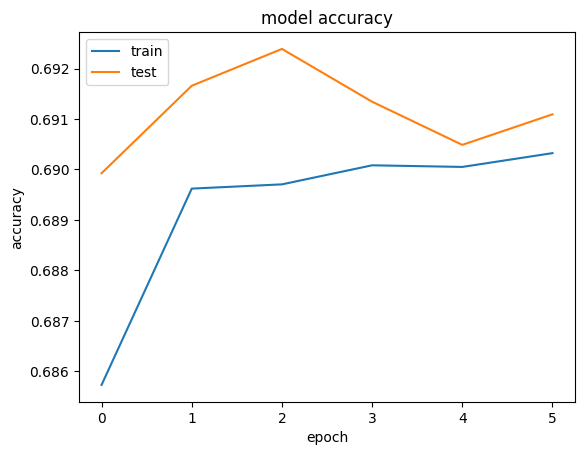

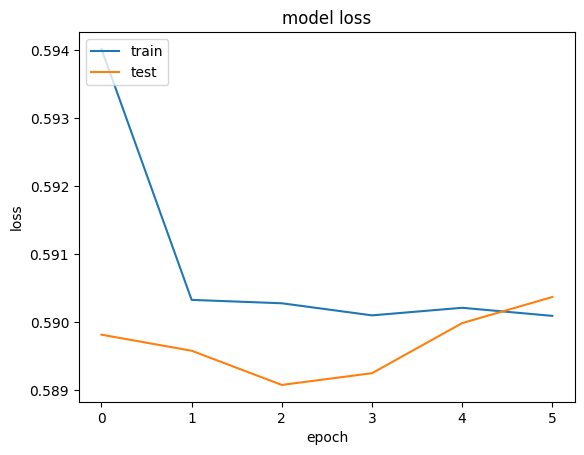

In [32]:

plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [34]:
cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [35]:
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          32214400  
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 32,278,657
Trainable params: 64,257
Non-trainable params: 32,214,400
_________________________________________________________________
None


In [36]:
cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
8000/8000 [==============================] - 29s 3ms/step - loss: 0.5205 - acc: 0.7382 - val_loss: 0.5043 - val_acc: 0.7489
Epoch 2/6
8000/8000 [==============================] - 25s 3ms/step - loss: 0.4952 - acc: 0.7565 - val_loss: 0.4982 - val_acc: 0.7549
Epoch 3/6
8000/8000 [==============================] - 25s 3ms/step - loss: 0.4841 - acc: 0.7642 - val_loss: 0.5009 - val_acc: 0.7520
Epoch 4/6
8000/8000 [==============================] - 25s 3ms/step - loss: 0.4761 - acc: 0.7695 - val_loss: 0.4966 - val_acc: 0.7558
Epoch 5/6
8000/8000 [==============================] - 25s 3ms/step - loss: 0.4703 - acc: 0.7732 - val_loss: 0.5034 - val_acc: 0.7519
Epoch 6/6
8000/8000 [==============================] - 25s 3ms/step - loss: 0.4654 - acc: 0.7768 - val_loss: 0.5040 - val_acc: 0.7525


In [37]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.5903201699256897
Test Accuracy: 0.6905875205993652


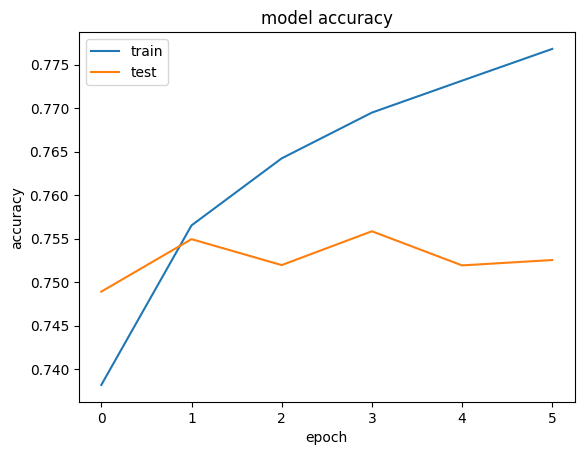

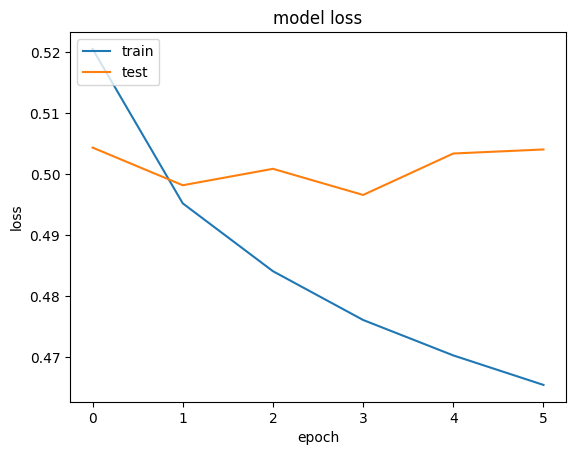

In [38]:
plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

In [43]:
rnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
rnn_model.add(embedding_layer)

rnn_model.add(SimpleRNN(128))

rnn_model.add(Dense(1, activation='sigmoid'))

rnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

rnn_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 100)          32214400  
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               29312     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 32,243,841
Trainable params: 29,441
Non-trainable params: 32,214,400
_________________________________________________________________


In [44]:
rnn_model_history = rnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
8000/8000 [==============================] - 558s 70ms/step - loss: 0.6933 - accuracy: 0.5047 - val_loss: 0.6935 - val_accuracy: 0.4994
Epoch 2/6
8000/8000 [==============================] - 555s 69ms/step - loss: 0.6941 - accuracy: 0.5007 - val_loss: 0.6931 - val_accuracy: 0.5007
Epoch 3/6
8000/8000 [==============================] - 537s 67ms/step - loss: 0.6943 - accuracy: 0.5003 - val_loss: 0.6932 - val_accuracy: 0.4991
Epoch 4/6
8000/8000 [==============================] - 538s 67ms/step - loss: 0.6944 - accuracy: 0.5005 - val_loss: 0.6932 - val_accuracy: 0.5020
Epoch 5/6
8000/8000 [==============================] - 541s 68ms/step - loss: 0.6944 - accuracy: 0.5002 - val_loss: 0.6944 - val_accuracy: 0.4985
Epoch 6/6
8000/8000 [==============================] - 539s 67ms/step - loss: 0.6944 - accuracy: 0.5017 - val_loss: 0.6960 - val_accuracy: 0.5038


In [45]:
score = rnn_model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

10000/10000 [==============================] - 167s 17ms/step - loss: 0.6960 - accuracy: 0.5040
Test Score: 0.6959621906280518
Test Accuracy: 0.5039593577384949


In [46]:
lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

In [47]:
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 100)          32214400  
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 32,331,777
Trainable params: 117,377
Non-trainable params: 32,214,400
_________________________________________________________________
None


In [48]:
lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
8000/8000 [==============================] - 80s 10ms/step - loss: 0.6932 - acc: 0.5005 - val_loss: 0.6932 - val_acc: 0.5007
Epoch 2/6
8000/8000 [==============================] - 78s 10ms/step - loss: 0.6932 - acc: 0.4992 - val_loss: 0.6931 - val_acc: 0.4993
Epoch 3/6
8000/8000 [==============================] - 76s 10ms/step - loss: 0.6932 - acc: 0.4999 - val_loss: 0.6932 - val_acc: 0.4993
Epoch 4/6
8000/8000 [==============================] - 76s 9ms/step - loss: 0.6932 - acc: 0.5002 - val_loss: 0.6932 - val_acc: 0.4993
Epoch 5/6
8000/8000 [==============================] - 76s 9ms/step - loss: 0.6932 - acc: 0.5011 - val_loss: 0.6932 - val_acc: 0.4993
Epoch 6/6
8000/8000 [==============================] - 77s 10ms/step - loss: 0.6932 - acc: 0.4997 - val_loss: 0.6931 - val_acc: 0.5007


In [49]:
score = lstm_model.evaluate(X_test, y_test, verbose=1)

10000/10000 [==============================] - 43s 4ms/step - loss: 0.6932 - acc: 0.5000


In [50]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.6932200789451599
Test Accuracy: 0.499965637922287


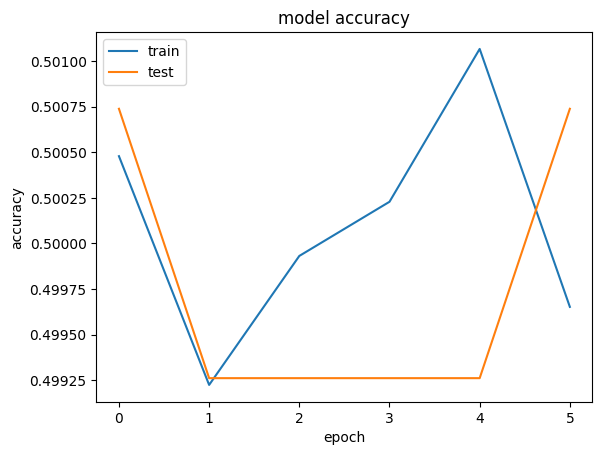

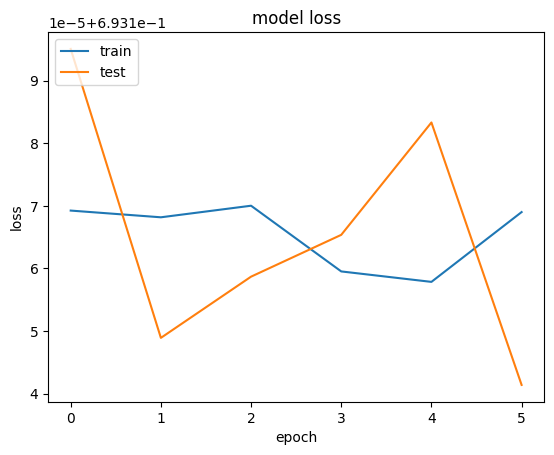

In [51]:
plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()